In [1]:
import warnings
warnings.filterwarnings("ignore")

## Data Cleaning and Exploring

In [1]:
import pandas as pd
import string 
import re
import unicodedata

from functions import (remove_punctuation, 
                       contains_non_turkish,
                       remove_words_without_non_turkish,
                       remove_substring, remove_consecutive_duplicates)

In [2]:
df = pd.read_csv("transcript_files/cleaned_full.csv")

In [5]:
df = df[df["name"] != "name"] # some values has 'name' in it, a small mistake. Drop them.

df['name'] = df['name'].str.title() # convert to string
df["transcript"] = df["transcript"].apply(lambda x: x.lower()) # lowercase everything in 'transcript' column    

# apply predefined functions
df["transcript"] = df["transcript"].apply(remove_punctuation)
df["transcript"] = df["transcript"].apply(remove_words_without_non_turkish)
df = remove_substring(df)
df["transcript"] = df["transcript"].apply(remove_consecutive_duplicates)

df.head()

,name,transcript,type
0,Arog,bak ne diyor logarı ki alın benim gemiyi korey...,KOMEDI
1,Abimm,o yüzden onların planına uyacağız çok dakika o...,DRAM
2,Acıların Kadını Bergen,yıllar yıllık dert yolunda ne ilk neden sonunc...,DRAM
3,Allahın Evi,allah şüphesiz alemlere bereket ve hidayet kay...,DRAM
4,Arekalar Ve Cinler,sude neredesin korkuyorum sude nerede kaldın b...,KORKU


In [6]:
# check if we have any N/A values
df.isna().sum()

name          0
transcript    0
type          0
dtype: int64

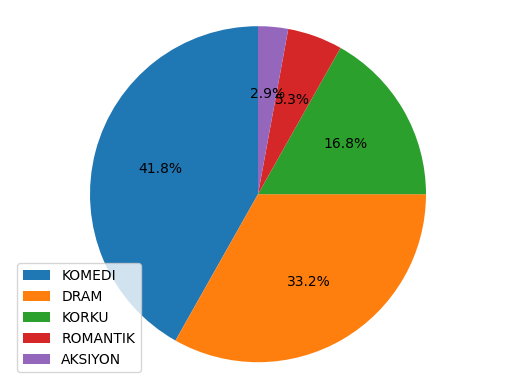

In [7]:
import matplotlib.pyplot as plt

type_counts = df["type"].value_counts()
plt.pie(type_counts, labels=None, autopct='%1.1f%%', startangle=90)

plt.axis('equal')  
plt.legend(labels=type_counts.index, loc='lower left')
plt.title("Distribution of Types")
plt.show()

In [6]:
df.to_csv("transcript_files/final_dataset.csv", index=False) # save the dataframe

## Tokenizing

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [9]:
from TurkishStemmer import TurkishStemmer
stemmer = TurkishStemmer()

In [10]:
# !pip install https://huggingface.co/turkish-nlp-suite/tr_core_news_trf/resolve/main/tr_core_news_trf-any-py3-none-any.whl
import spacy
from spacy.lang.tr import stop_words

stop_words = stop_words.STOP_WORDS

nlp = spacy.load("tr_core_news_trf")
nlp.max_length = 200_000

In [11]:
df.drop('name', axis=1, inplace=True)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X, Y = df["transcript"], df["type"]

# split into test and train
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1) 

In [14]:
X_train.shape,  Y_train.shape, X_test.shape, Y_test.shape

((166,), (166,), (42,), (42,))

In [15]:
X_train

73     en çok nüfus sende iki yüz doksan beni görmemi...
166    asker bu ne kıpa asker bu ne lastik bir daha b...
138    keşke onu siz de tanıyabilseydiniz bireyim bir...
199    tired to mym fless hıppprialuje nasıl build sa...
84     izlediğiniz için teşekkürler idam konusunda so...
                             ...                        
203    kalp krizi geçirmeyeyim mi şimdi genç yaşta öl...
137    lan telefon beyler hop nereye hesap mı demedin...
72     wwwseslibetimlemedernegicom beni iyi dinleyin ...
140    bulursa jandarmaya da vermez bu işten kurtulam...
37     sen bana bir he desen var ya kira mira yok ev ...
Name: transcript, Length: 166, dtype: object

In [16]:
Y_train

73     KOMEDI
166    KOMEDI
138      DRAM
199    KOMEDI
84       DRAM
        ...  
203    KOMEDI
137      DRAM
72       DRAM
140    KOMEDI
37     KOMEDI
Name: type, Length: 166, dtype: object

In [14]:
tokenizer = Tokenizer(num_words=9800, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

tokenized_sentences = []
for sentence in X_train: # in train split
    doc = nlp(sentence) # tokenize each row
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words] # stem each word if it is not a stop word
    stemmed_tokens = [stemmer.stem(token) for token in tokens]  # apply stemming to each token
    tokenized_sentences.append(" ".join(stemmed_tokens))

tokenizer.fit_on_texts(tokenized_sentences) # train the tokenizer
word_index = tokenizer.word_index

In [15]:
sequences = tokenizer.texts_to_sequences(tokenized_sentences) # convert to numeric values
max_sequence_length = max(len(seq) for seq in sequences) # the longest sequence length
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length) # pad the sequences to ensure uniform length 

In [16]:
X_train = padded_sequences

In [17]:
Y_train

73     KOMEDI
166    KOMEDI
138      DRAM
199    KOMEDI
84       DRAM
        ...  
203    KOMEDI
137      DRAM
72       DRAM
140    KOMEDI
37     KOMEDI
Name: type, Length: 166, dtype: object

*We need to convert categoric values to numeric*

In [27]:
from sklearn.preprocessing import LabelEncoder

In [18]:
le = LabelEncoder()
Y_train = le.fit_transform(Y_train) # convert to numeric

classes_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class Mapping:", classes_mapping)

Class Mapping: {'AKSIYON': 0, 'DRAM': 1, 'KOMEDI': 2, 'KORKU': 3, 'ROMANTIK': 4}


In [19]:
X.shape, Y.shape

((208,), (208,))

In [23]:
X_train

array([[   0,    0,    0, ...,   75,   75,    7],
       [   0,    0,    0, ..., 1828,  554,  526],
       [   0,    0,    0, ..., 6339,  554,  526],
       ...,
       [   0,    0,    0, ...,   22,  554,  526],
       [   0,    0,    0, ...,  135, 2957, 9474],
       [   0,    0,    0, ...,    7,  411,   27]])

In [22]:
Y_train

array([2, 2, 1, 2, 1, 2, 2, 0, 1, 1, 2, 1, 1, 2, 2, 0, 2, 1, 1, 2, 2, 0,
       2, 2, 1, 2, 3, 1, 2, 4, 0, 1, 2, 1, 1, 1, 2, 3, 1, 1, 3, 3, 1, 3,
       1, 4, 4, 1, 1, 1, 2, 1, 0, 3, 4, 3, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2,
       1, 2, 3, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 4, 3, 3, 2, 4, 2, 1, 2, 1,
       1, 1, 1, 1, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 3, 2, 3,
       1, 3, 2, 0, 2, 1, 2, 1, 2, 1, 1, 3, 3, 1, 4, 2, 3, 3, 2, 2, 3, 2,
       2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 4, 2, 2, 1, 1, 1, 3, 2, 2, 2, 3,
       2, 4, 2, 3, 2, 4, 2, 2, 1, 1, 2, 2])

## Train Different Models

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [25]:
model = RandomForestClassifier(n_estimators=100, max_depth=20)
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=20)

In [26]:
print("tokenizing")
tokenized_sentences_test = []
for sentence in X_test:
    doc = nlp(sentence)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words]
    stemmed_tokens = [stemmer.stem(token) for token in tokens]  # apply stemming to each token
    tokenized_sentences_test.append(" ".join(stemmed_tokens))

sequences_test = tokenizer.texts_to_sequences(tokenized_sentences_test)
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_sequence_length)

Y_test_encoded = le.transform(Y_test)


tokenizing


In [27]:
print("predicting")
predictions = model.predict(padded_sequences_test)
accuracy = accuracy_score(Y_test_encoded, predictions)
print(f"Accuracy: {accuracy:.2f}")

predicting
Accuracy: 0.67


In [34]:
class_mapping = {0: 'AKSIYON', 1: 'DRAM', 2: 'KOMEDI', 3: 'KORKU', 4: 'ROMANTIK'}

for i in range(len(predictions)):
    true_class = class_mapping[Y_test_encoded[i]]
    predicted_class = class_mapping[predictions[i]]
    print(f"True: {true_class}, Predicted: {predicted_class}")

True: KOMEDI, Predicted: KOMEDI
True: KORKU, Predicted: KORKU
True: KORKU, Predicted: DRAM
True: KOMEDI, Predicted: KOMEDI
True: KOMEDI, Predicted: KOMEDI
True: KOMEDI, Predicted: KOMEDI
True: KOMEDI, Predicted: KOMEDI
True: DRAM, Predicted: DRAM
True: DRAM, Predicted: KORKU
True: KOMEDI, Predicted: KOMEDI
True: KORKU, Predicted: DRAM
True: DRAM, Predicted: DRAM
True: DRAM, Predicted: DRAM
True: KORKU, Predicted: DRAM
True: KORKU, Predicted: DRAM
True: KOMEDI, Predicted: KOMEDI
True: KORKU, Predicted: DRAM
True: KOMEDI, Predicted: KOMEDI
True: KORKU, Predicted: DRAM
True: KOMEDI, Predicted: KOMEDI
True: DRAM, Predicted: KOMEDI
True: KOMEDI, Predicted: KOMEDI
True: KORKU, Predicted: DRAM
True: ROMANTIK, Predicted: KOMEDI
True: KOMEDI, Predicted: KOMEDI
True: KOMEDI, Predicted: KOMEDI
True: DRAM, Predicted: KOMEDI
True: DRAM, Predicted: KOMEDI
True: KOMEDI, Predicted: KOMEDI
True: DRAM, Predicted: KORKU
True: DRAM, Predicted: DRAM
True: KOMEDI, Predicted: KOMEDI
True: KORKU, Predicted: K

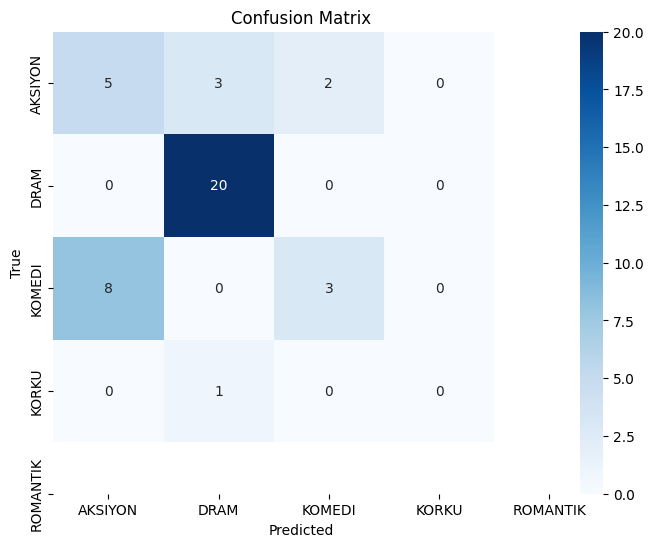

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(Y_test_encoded, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Neural Network Models

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
import numpy as np

# Model 1

## A sequential neural network model using Tensorflow & Keras

### 1. Embedding Layer:
   - We use Embedding because our Model will need to know which words are similar and which are not. Will be useful to determine the meanings of the words.

### 2. Bidirectional LSTM:
   - LSTM's are powerful in understanding context by processing input sequences, Bidirectional LSTM can process data in both forward and backward directions. It allows model to capture more data, both from the past and the future steps.
  
### 3. Dense Layer:
   - Takes what is returned from the last layer as input, returns the predicted output. Output units equal to the number of classes in the target.

### 4. Compilation:
   - **Optimizer:** Adam optimizer.
   - **Loss Function:** Sparse Categorical Crossentropy
   - **Evaluation Metric:** Accuracy

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index) + 1, output_dim=100, input_length=X_train.shape[1]))
model.add(Bidirectional(LSTM(100, return_sequences=True)))
model.add(LSTM(100))
model.add(Dense(len(classes_mapping), activation='sigmoid'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=5, batch_size=8)

predictions = model.predict(padded_sequences_test)

In [44]:
accuracy = accuracy_score(Y_test_encoded, np.argmax(predictions, axis=1))
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.29


In [88]:
model.save("saved models/acc29.h5")

# Model 2

## Simpler Neural Network with LSTMs
**Adjusting for Overfitting:**
Since the first model overfit, I may need to reduce the power of the model and change some hyperparameters.

**Changes:**
- I reduced the number of Bidirectional LSTMs.
- Changed the output dimension of Embedding from 100 to 150.

**Results:**
- I ended up getting better results. %29 to 48, **+%65** improvement!c:** Accuracy


In [51]:
model1 = Sequential()
model1.add(Embedding(input_dim=len(word_index) + 1, output_dim=150, input_length=X_train.shape[1]))
model1.add(Bidirectional(LSTM(150, return_sequences=True)))
model1.add(LSTM(150))
model1.add(Dense(len(classes_mapping), activation='sigmoid'))
# Compile the model
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model1.fit(X_train, Y_train, epochs=5, batch_size=8)

predictions = model1.predict(padded_sequences_test)
accuracy = accuracy_score(Y_test_encoded, np.argmax(predictions, axis=1))
print(f"Accuracy: {accuracy:.2f}")

Epoch 1/5
21/21 [==============================] - 164s 8s/step - loss: 1.5015 - accuracy: 0.3253
Epoch 2/5
21/21 [==============================] - 174s 8s/step - loss: 1.2532 - accuracy: 0.4458
Epoch 3/5
21/21 [==============================] - 179s 9s/step - loss: 0.9602 - accuracy: 0.6265
Epoch 4/5
21/21 [==============================] - 183s 9s/step - loss: 0.3998 - accuracy: 0.8434
Epoch 5/5
2/2 [==============================] - 14s 839ms/step
Accuracy: 0.48


In [87]:
model1.save("saved models/acc48.h5")

# Model 3

## Same Model with Different Number of Output Dimension
*Last time it helped the model to learn better, so I will play with the output_dim.*
  
**Changes:**
- Changed the output dimension of Embedding from 150 to 200.

**Results:**
- I ended up getting way worse results. %48 to 31, **%35** degradation!

In [52]:
model2 = Sequential()
model2.add(Embedding(input_dim=len(word_index) + 1, output_dim=200, input_length=X_train.shape[1]))
model2.add(Bidirectional(LSTM(200, return_sequences=True)))
model2.add(LSTM(200))
model2.add(Dense(len(classes_mapping), activation='softmax'))
# Compile the model
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model2.fit(X_train, Y_train, epochs=5, batch_size=8)

predictions = model2.predict(padded_sequences_test)
accuracy = accuracy_score(Y_test_encoded, np.argmax(predictions, axis=1))
print(f"Accuracy: {accuracy:.2f}")

Epoch 1/5
21/21 [==============================] - 253s 12s/step - loss: 1.4470 - accuracy: 0.4217
Epoch 2/5
21/21 [==============================] - 269s 13s/step - loss: 1.2888 - accuracy: 0.3855
Epoch 3/5
21/21 [==============================] - 280s 13s/step - loss: 0.8922 - accuracy: 0.6928
Epoch 4/5
21/21 [==============================] - 288s 14s/step - loss: 0.4840 - accuracy: 0.8434
Epoch 5/5
2/2 [==============================] - 21s 2s/step
Accuracy: 0.31


In [86]:
model2.save("saved models/acc31.h5")

# Model 4

## Deeper and Stronger Neural Network with Multiple LSTMs
**Changes:**
- I added a new Bidirectional LSTM.
- Changed the output dimension of Embedding from 200 to 256.

**Results:**
- I ended up getting better result than the last model. %31 to 40, **~%30** improvement!

In [ ]:
model3 = Sequential()
model3.add(Embedding(input_dim=len(word_index) + 1, output_dim=256, input_length=X_train.shape[1]))
model3.add(Bidirectional(LSTM(256, return_sequences=True, stateful=True)))
model3.add(Bidirectional(LSTM(128, return_sequences=True, stateful=True)))
model3.add(LSTM(128, stateful=True))
model3.add(Dense(len(classes_mapping), activation='softmax'))
# Compile the model
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model3.fit(X_train, Y_train, epochs=5, batch_size=8)

predictions = model3.predict(padded_sequences_test)
accuracy = accuracy_score(Y_test_encoded, np.argmax(predictions, axis=1))
print(f"Accuracy: {accuracy:.2f}")

In [ ]:
model3.save("saved models/acc40.h5")

# Trying Sklearn Models

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [56]:
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, Y_train)
logreg_predictions = logreg.predict(padded_sequences_test)

print("Logistic Regression Accuracy:", accuracy_score(Y_test_encoded, logreg_predictions))
print("Logistic Regression Classification Report:\n", classification_report(Y_test_encoded, logreg_predictions))
#####################

svm = SVC(kernel='linear')
svm.fit(X_train, Y_train)
svm_predictions = svm.predict(padded_sequences_test)

print("SVM Accuracy:", accuracy_score(Y_test_encoded, svm_predictions))
print("SVM Classification Report:\n", classification_report(Y_test_encoded, svm_predictions))
#####################

dtree = DecisionTreeClassifier()
dtree.fit(X_train, Y_train)
dtree_predictions = dtree.predict(padded_sequences_test)

print("Decision Tree Accuracy:", accuracy_score(Y_test_encoded, dtree_predictions))
print("Decision Tree Classification Report:\n", classification_report(Y_test_encoded, dtree_predictions))
#####################

rf = RandomForestClassifier()
rf.fit(X_train, Y_train)
rf_predictions = rf.predict(padded_sequences_test)

print("Random Forest Accuracy:", accuracy_score(Y_test_encoded, rf_predictions))
print("Random Forest Classification Report:\n", classification_report(Y_test_encoded, rf_predictions))
#####################

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)
knn_predictions = knn.predict(padded_sequences_test)

print("k-Nearest Neighbors Accuracy:", accuracy_score(Y_test_encoded, knn_predictions))
print("k-Nearest Neighbors Classification Report:\n", classification_report(Y_test_encoded, knn_predictions))

Logistic Regression Accuracy: 0.5476190476190477
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           1       0.33      0.60      0.43        10
           2       0.79      0.75      0.77        20
           3       0.40      0.18      0.25        11
           4       0.00      0.00      0.00         1

    accuracy                           0.55        42
   macro avg       0.38      0.38      0.36        42
weighted avg       0.56      0.55      0.53        42

SVM Accuracy: 0.5238095238095238
SVM Classification Report:
               precision    recall  f1-score   support

           1       0.26      0.50      0.34        10
           2       0.78      0.70      0.74        20
           3       0.60      0.27      0.37        11
           4       0.00      0.00      0.00         1

    accuracy                           0.52        42
   macro avg       0.41      0.37      0.36        42
weighted avg       0.59      0.

In [84]:
from joblib import dump

dump(logreg, "saved models/logreg54.joblib")
dump(svm, "saved models/svm52.joblib")
dump(dtree, "saved models/dtree50.joblib")
dump(rf, "saved models/rf64.joblib")
dump(knn, "saved models/knn21.joblib")

['saved models/knn21.joblib']

## Performance Comparison

### Logistic Regression:
- **Accuracy:** 40%
- **F1 Score:** 0.43
- **Recall:** 0.6

### Support Vector Machine (SVM):
- **Accuracy:** 52%
- **F1 Score:** 0.34
- **Recall:** 0.5

### Decision Tree:
- **Accuracy:** 50%
- **F1 Score:** 0.36
- **Recall:** 0.50

### Random Forest:
- **Accuracy:** 64%
- **F1 Score:** 0.43
- **Recall:** 0.5

### k-Nearest Neighbors (KNN):
- **Accuracy:** 2**Observations:**
- Random Forest achieved the highest accuracy at 64%, outperforming other models.
- Logistic Regression exhibited a balanced F1 Score and Recall, suggesting a reasonable trade-off between precision and sensitivity.
- SVM showed a relatively high accuracy but lower F1 Score and Recall, indicating potential challenges in handling imbalances in the data or sensitivity to certain classes.
- Decision Tree and Random Forest have similar F1 Scores, but Random Forest outperformed in terms of accuracy.
- KNN has the lowest accuracy among the moels.- **Recall:** 0.6 0.5.6


#### Passive Aggressive Classifier

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_v = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))

In [ ]:
tfidf_X = tfidf_v.fit_transform(tokenized_sentences).toarray()
tfidf_Y = Y_train

In [75]:
tfidf_X

array([[0.02466967, 0.        , 0.        , ..., 0.        , 0.        ,
        0.00497822],
       [0.00797245, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00285757, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00929373, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [76]:
tfidf_Y

array([2, 2, 1, 2, 1, 2, 2, 0, 1, 1, 2, 1, 1, 2, 2, 0, 2, 1, 1, 2, 2, 0,
       2, 2, 1, 2, 3, 1, 2, 4, 0, 1, 2, 1, 1, 1, 2, 3, 1, 1, 3, 3, 1, 3,
       1, 4, 4, 1, 1, 1, 2, 1, 0, 3, 4, 3, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2,
       1, 2, 3, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 4, 3, 3, 2, 4, 2, 1, 2, 1,
       1, 1, 1, 1, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 3, 2, 3,
       1, 3, 2, 0, 2, 1, 2, 1, 2, 1, 1, 3, 3, 1, 4, 2, 3, 3, 2, 2, 3, 2,
       2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 4, 2, 2, 1, 1, 1, 3, 2, 2, 2, 3,
       2, 4, 2, 3, 2, 4, 2, 2, 1, 1, 2, 2])

In [77]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_X, tfidf_Y, test_size=0.2, random_state=0)

In [78]:
from sklearn.linear_model import PassiveAggressiveClassifier

classifier = PassiveAggressiveClassifier(max_iter=1000)

In [79]:
from sklearn import metrics
import itertools

classifier.fit(x_train, y_train)

pred = classifier.predict(x_test)

score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.529


Confusion matrix, without normalization


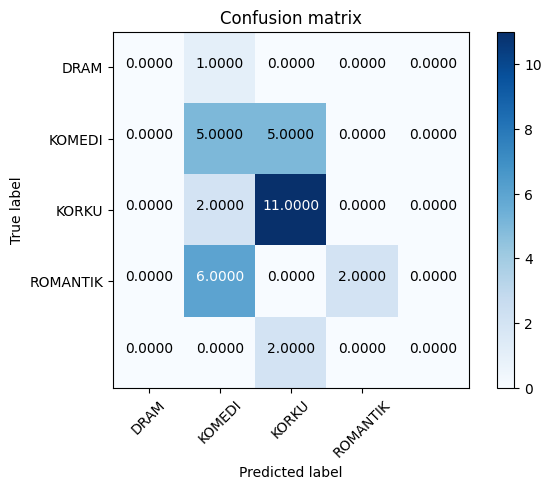

In [80]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cm = metrics.confusion_matrix(y_test, pred)
plot_confusion_matrix(cm, classes=['DRAM', 'KOMEDI', 'KORKU', 'ROMANTIK'])

##### Classification with TF-IDF Vectorizer and PassiveAggressiveClassifier
In this code chunk, text classification is performed using a TF-IDF (Term Frequency-Inverse Document Frequency) vectorizer and the PassiveAggressiveClassifier from scikit-learn.
1. **TF-IDF Vectorizer:**
   - The `TfidfVectorizer` is utilized with a maximum of 5000 features and n-gram range from unigrams to trigrams (`ngram_range=(1, 3)`). This vectorizer converts text data into a numerical format suitable for machine learning. 2.

3. **PassiveAggressive Classifier:**
   - The `PassiveAggressiveClassifier` is employed with a maximum of 1000 iterations for trai3ing.

4. **Model Training:**
   - The classifier is trained using the training data (`x_train` and `y_4rain`).

5. **Prediction and Evaluation:**
   - Predictions are made on the test data, and accuracy is calculated using the `metrics.accuracy_score` function.

6. **Confusion Matrix:**
   - The confusion matrix is printed to evaluate the classifier's performance. The rows represent actual classes, and columns represent pr

<table>
     <tr>
       <td><strong>Actual\Predicted</strong></td>
       <td><strong style="color: #1f77b4">DRAM</strong></td>
       <td><strong style="color: #ff7f0e">KOMEDI</strong></td>
       <td><strong style="color: #2ca02c">KORKU</strong></td>
       <td><strong style="color: #d62728">ROMANTIK</strong></td>
     </tr>
     <tr>
       <td><strong style="color: #1f77b4">DRAM</strong></td>
       <td style="background-color: #d62728">0</td>
       <td style="background-color: #ff7f0e">1</td>
       <td>0</td>
       <td>0</td>
     </tr>
     <tr>
       <td><strong style="color: #ff7f0e">KOMEDI</strong></td>
       <td>0</td>
       <td style="background-color: #ff7f0e">5</td>
       <td style="background-color: #2ca02c">5</td>
       <td>0</td>
     </tr>
     <tr>
       <td><strong style="color: #2ca02c">KORKU</strong></td>
       <td>0</td>
       <td>2</td>
       <td style="background-color: #2ca02c">11</td>
       <td>0</td>
     </tr>
     <tr>
       <td><strong style="color: #d62728">ROMANTIK</strong></td>
       <td>0</td>
       <td style="background-color: #d62728">6</td>
       <td>0</td>
       <td style="background-color: #d62728">2</td>
     </tr>
</table>


# Training with more Balanced Dataset

*This time, I will drop 'AKSIYON' column since we have less data, also confuses the model*

In [ ]:
df = pd.read_csv("transcript_files/final_dataset.csv")

In [ ]:
df = df[df["type"] != "AKSIYON"]
df = df[df["name"] != "Ev"]
df = df[df["name"] != "Dabbe 4"]
df = df[df["name"] !=  "Kendime Iyi Bak"]

In [ ]:
df.shape

In [ ]:
df.isna().any()

In [ ]:
import matplotlib.pyplot as plt

type_counts = df["type"].value_counts()
plt.pie(type_counts, labels=None, autopct='%1.1f%%', startangle=90)

plt.axis('equal')  
plt.legend(labels=type_counts.index, loc='lower left')
plt.show()

In [8]:
import spacy
from spacy.lang.tr import stop_words

nlp = spacy.load("tr_core_news_trf")
nlp.max_length = 200_000
stop_words = stop_words.STOP_WORDS

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.preprocessing.text import Tokenizer

from TurkishStemmer import TurkishStemmer
stemmer = TurkishStemmer()

from sklearn.model_selection import train_test_split

C:\Users\Cihan\Desktop\web\ML\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df.drop("name", axis=1, inplace=True)
X, Y = df["transcript"], df["type"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [ ]:
tokenizer = Tokenizer(num_words=9800, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

tokenized_sentences = []
for sentence in X_train:
    doc = nlp(sentence)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words]
    stemmed_tokens = [stemmer.stem(token) for token in tokens]  # Apply stemming to each token
    tokenized_sentences.append(" ".join(stemmed_tokens))

tokenizer.fit_on_texts(tokenized_sentences)
word_index = tokenizer.word_index

In [ ]:
sequences = tokenizer.texts_to_sequences(tokenized_sentences)
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y_train = le.fit_transform(Y_train)

classes_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class Mapping:", classes_mapping)

In [ ]:
X_train = padded_sequences

In [ ]:
print("tokenizing")
tokenized_sentences_test = []
for sentence in X_test:
    doc = nlp(sentence)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words]
    stemmed_tokens = [stemmer.stem(token) for token in tokens]  # Apply stemming to each token
    tokenized_sentences_test.append(" ".join(stemmed_tokens))

sequences_test = tokenizer.texts_to_sequences(tokenized_sentences_test)
padded_sequences_test = pad_sequences(sequences_test, maxlen=max_sequence_length)

Y_test_encoded = le.transform(Y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

model = RandomForestClassifier(n_estimators=100, max_depth=20)
model.fit(X_train, Y_train)

In [ ]:
print("predicting")
predictions = model.predict(padded_sequences_test)
accuracy = accuracy_score(Y_test_encoded, predictions)
print(f"Accuracy: {accuracy:.2f}")

# PassiveAggressiveClassifier with TfidfVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_v = TfidfVectorizer(max_features=5000, ngram_range=(1, 3))

In [ ]:
tfidf_X = tfidf_v.fit_transform(tokenized_sentences).toarray()
tfidf_Y = Y_train

In [ ]:
tfidf_Y

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_X, tfidf_Y, test_size=0.2, random_state=0)

In [ ]:
from sklearn import metrics
import numpy as np
import itertools

from sklearn.linear_model import PassiveAggressiveClassifier

classifier = PassiveAggressiveClassifier(max_iter=1000)

In [ ]:
classifier.fit(x_train, y_train)

pred = classifier.predict(x_test)

score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

class_labels = ['DRAM', 'KOMEDI', 'KORKU', 'ROMANTIK']

# Calculate confusion matrix
conf_mat = confusion_matrix(y_test, pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Make the Dataset more balanced using scikit-learn *'compute_class_weight'*.

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

classifier = LogisticRegression(class_weight=class_weight_dict)
classifier.fit(x_train, y_train)

pred = classifier.predict(x_test)

accuracy = accuracy_score(y_test, pred)
report = classification_report(y_test, pred)

print("Accuracy:", accuracy)
print("Classification Report:\n", report)


# PreTrained HuggingFace BERT model

In [17]:
import pandas as pd
df = pd.read_csv("transcript_files/preprocess2.csv")
df.drop('name', axis=1, inplace=True)
df.head()

,transcript,type
0,bak ne diyor logarı ki alın benim gemiyi korey...,KOMEDI
1,o yüzden onların planına uyacağız çok dakika o...,DRAM
2,yıllar yıllık dert yolunda ne ilk neden sonunc...,DRAM
3,allah şüphesiz alemlere bereket ve hidayet kay...,DRAM
4,sude neredesin korkuyorum sude nerede kaldın b...,KORKU


In [18]:
num_classes = len(df["type"].unique())

In [19]:
from transformers import BertTokenizer, BertForSequenceClassification

import torch
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset

from tqdm import tqdm

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on {device}")

Running on cuda


In [21]:
model_name = "dbmdz/bert-base-turkish-128k-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes).to(device)

Some weights of the model checkpoint at dbmdz/bert-base-turkish-128k-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassificatio

In [22]:
class MovieDataset(Dataset):
    """
    Our custom Dataset class inherited from torch.Dataset
    """
      def __init__(self, df, tokenizer, max_len):
          self.df = df
          self.tokenizer = tokenizer
          self.max_len = max_len
          self.labels = LabelEncoder().fit_transform(df["type"]) # handles categorical data in target column

      def __len__(self):
          return len(self.df)

      def __getitem__(self, index):
          transcript = str(self.df["transcript"].iloc[index])
          label = self.labels[index]

          input_dict = self.tokenizer(
             transcript,
             padding="max_length",
             truncation=True,
             max_length=self.max_len,
             return_tensors='pt'
          )

          return {
            'input_ids': input_dict['input_ids'].flatten(),
            'attention_mask': input_dict['attention_mask'].flatten(),
            'token_type_ids': input_dict['token_type_ids'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
          }


In [23]:
# split the data
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=0)

In [24]:
# hyperparameters
MAX_LEN=40
TRAIN_BATCH_SIZE=8
VALID_BATCH_SIZE=8
EPOCHS=3
LR=5e-5

In [28]:
train_dataset = MovieDataset(train_df, tokenizer, MAX_LEN)
valid_dataset = MovieDataset(valid_df, tokenizer, MAX_LEN)

In [29]:
# get DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)

In [30]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

In [31]:
valid_accuracy = []

for epoch in range(EPOCHS):
    # Train loop
    model.train()
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/ {EPOCHS}"):
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for batch in tqdm(valid_dataloader, desc=f"Validation Epoch {epoch + 1}/{EPOCHS}"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'label'}
            labels = batch['label'].to(device)

            outputs = model(**inputs)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=1)

            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

        accuracy = total_correct / total_samples
        valid_accuracy.append(accuracy)
        print(f"Validation Accuracy: {accuracy}")

Validation Epoch 1/3: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


Validation Accuracy: 0.325


Validation Epoch 2/3: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


Validation Accuracy: 0.325


Validation Epoch 3/3: 100%|██████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]

Validation Accuracy: 0.5


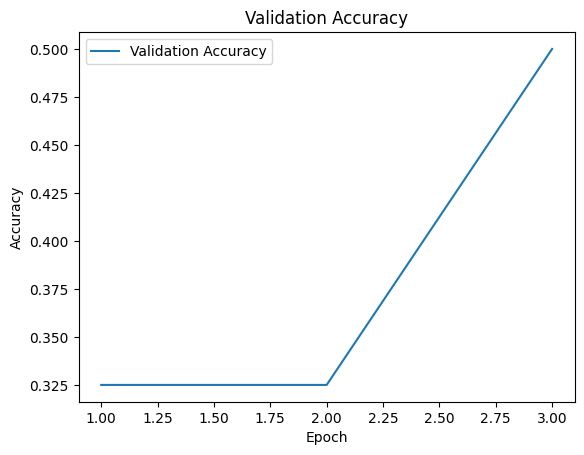

In [32]:
# plot the validation accuracy
import matplotlib.pyplot as plt
plt.plot(range(1, EPOCHS + 1), valid_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

In [33]:
# save the finetuned model
model_save_directory = "finetuned"

model.save_pretrained(model_save_directory)

tokenizer.save_pretrained(model_save_directory)

('finetuned\\tokenizer_config.json',
 'finetuned\\special_tokens_map.json',
 'finetuned\\vocab.txt',
 'finetuned\\added_tokens.json')